In [5]:
import pandas as pd
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

import numpy as np

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sn

In [6]:
import statsmodels
print(statsmodels.__version__)

0.13.2


### Linear Regression Model

In [37]:
data = pd.read_csv('Written_Investigation_DATA.csv')

In [38]:
print(data)

    Year  Good_lift      GDP  GDP_rate  Production  Service  Exports  Imports  \
0   1998     1630.0   999326  0.047564        87.7     62.5   163776   189846   
1   1999     1567.0  1044150  0.044854        91.9     64.0   166343   199738   
2   2000     1593.0  1101143  0.054583        93.7     67.1   186798   226641   
3   2001     1581.0  1145323  0.040122        96.5     68.5   190648   239239   
4   2002     1627.0  1191515  0.040331        97.5     69.5   187404   241982   
5   2003     1643.0  1259675  0.057204       100.1     72.1   187877   245122   
6   2004     1743.7  1323420  0.050604        99.6     74.4   191049   258350   
7   2005     1745.9  1399643  0.057595        98.6     77.3   212494   286208   
8   2006     1775.8  1472837  0.052295       102.0     79.0   246418   328462   
9   2007     1822.4  1545792  0.049534       100.4     82.1   222677   316245   
10  2008     1667.5  1594737  0.031663        99.1     82.7   251905   347641   
11  2009     1356.2  1551882

In [39]:
# standardization
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

data_standardised = data.copy()
for c in data.columns.values:
    data_standardised[c] = mms.fit_transform(data[c].values.reshape(-1,1))
data_standardised.head()

,Year,Good_lift,GDP,GDP_rate,Production,Service,Exports,Imports,Hous_cons_exp,Retail,Postal&courier
0,0.000000,0.650563,0.000000,0.912861,0.094937,0.000000,0.000000,0.000000,0.000000,0.000000,0.530333
1,0.045455,0.536142,0.036177,0.889320,0.360759,0.040000,0.012853,0.030737,0.043020,0.033816,0.512720
2,0.090909,0.583364,0.082175,0.973833,0.474684,0.122667,0.115268,0.114331,0.087353,0.060386,0.769080
3,0.136364,0.561569,0.117832,0.848211,0.651899,0.160000,0.134544,0.153476,0.125633,0.106280,1.000000
4,0.181818,0.645114,0.155113,0.850027,0.715190,0.186667,0.118302,0.162000,0.158554,0.144928,0.502935


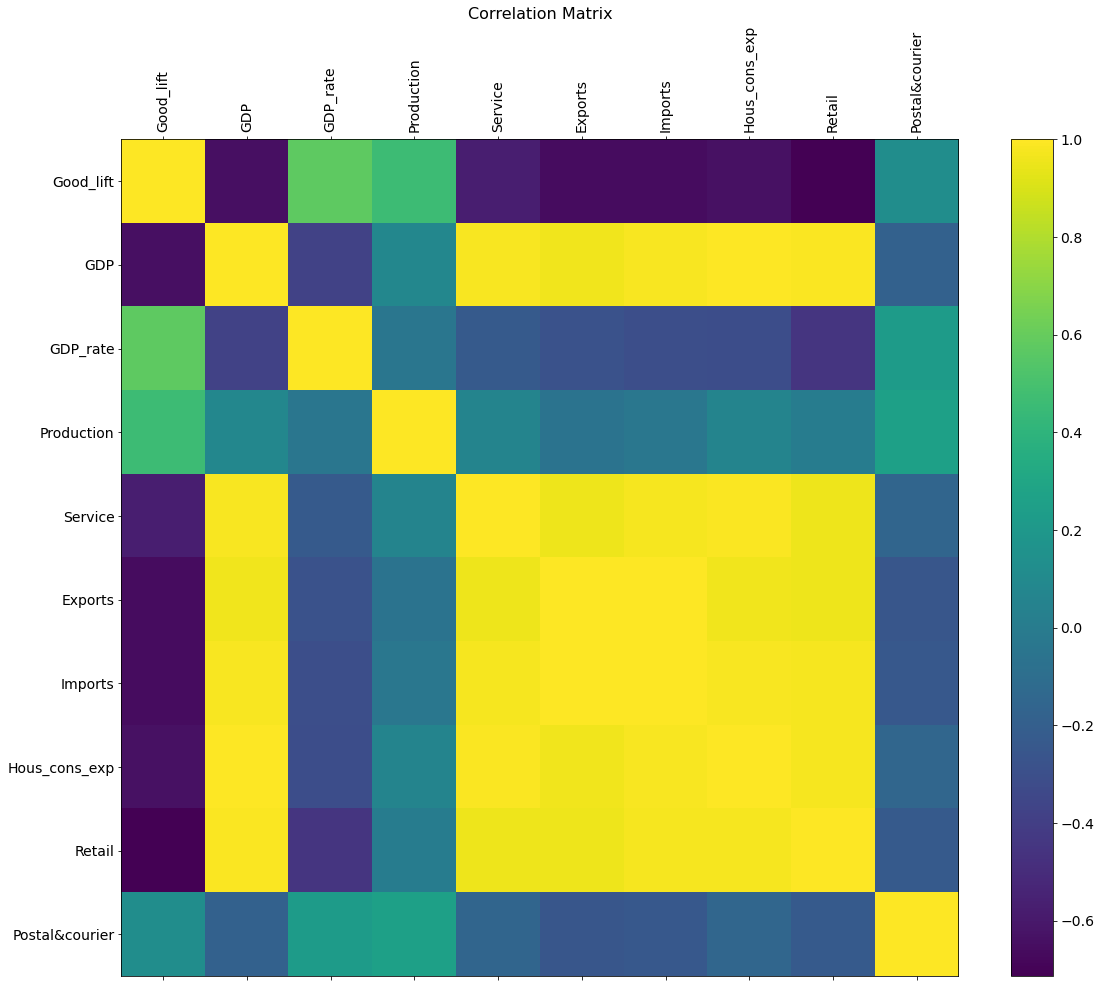

In [44]:
# plot correlation matrix
df = data_standardised[['Good_lift','GDP','GDP_rate','Production','Service','Exports','Imports','Hous_cons_exp','Retail','Postal&courier']]
plt.rcParams["axes.grid"] = False
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.shape[1]), df.columns, fontsize=14, rotation=90)
plt.yticks(range(df.shape[1]), df.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16)

plt.savefig("Correlation Matrix.png", bbox_inches = 'tight')  
plt.show()

In [45]:
df.head()

,Good_lift,GDP,GDP_rate,Production,Service,Exports,Imports,Hous_cons_exp,Retail,Postal&courier
0,0.650563,0.000000,0.912861,0.094937,0.000000,0.000000,0.000000,0.000000,0.000000,0.530333
1,0.536142,0.036177,0.889320,0.360759,0.040000,0.012853,0.030737,0.043020,0.033816,0.512720
2,0.583364,0.082175,0.973833,0.474684,0.122667,0.115268,0.114331,0.087353,0.060386,0.769080
3,0.561569,0.117832,0.848211,0.651899,0.160000,0.134544,0.153476,0.125633,0.106280,1.000000
4,0.645114,0.155113,0.850027,0.715190,0.186667,0.118302,0.162000,0.158554,0.144928,0.502935


In [46]:
# calculating VIF
# This function is adjusted from: https://stackoverflow.com/a/51329496/4667568
from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.tools.tools import add_constant

def drop_column_using_vif_(df, thresh=5):
    '''
    Calculates VIF each feature in a pandas dataframe, and repeatedly drop the columns with the highest VIF
    A constant must be added to variance_inflation_factor or the results will be incorrect

    :param df: the pandas dataframe containing only the predictor features, not the response variable
    :param thresh: (default 5) the threshould VIF value. If the VIF of a variable is greater than thresh, it should be removed from the dataframe
    :return: dataframe with multicollinear features removed
    '''
    while True:
        # adding a constatnt item to the data. add_constant is a function from statsmodels (see the import above)
        df_with_const = add_constant(df)

        vif_df = pd.Series([variance_inflation_factor(df_with_const.values, i) 
               for i in range(df_with_const.shape[1])], name= "VIF",
              index=df_with_const.columns).to_frame()

        # drop the const
        vif_df = vif_df.drop('const')
        
        # if the largest VIF is above the thresh, remove a variable with the largest VIF
        # If there are multiple variabels with VIF>thresh, only one of them is removed. This is because we want to keep as many variables as possible
        if vif_df.VIF.max() > thresh:
            # If there are multiple variables with the maximum VIF, choose the first one
            index_to_drop = vif_df.index[vif_df.VIF == vif_df.VIF.max()].tolist()[0]
            print('Dropping: {}'.format(index_to_drop))
            df = df.drop(columns = index_to_drop)
        else:
            # No VIF is above threshold. Exit the loop
            break

    return df

In [47]:
variable_final = drop_column_using_vif_(df.drop('Good_lift', axis=1))
print(variable_final)

Dropping: GDP
Dropping: Imports
Dropping: Hous_cons_exp
Dropping: Retail
Dropping: Exports
    GDP_rate  Production   Service  Postal&courier
0   0.912861    0.094937  0.000000        0.530333
1   0.889320    0.360759  0.040000        0.512720
2   0.973833    0.474684  0.122667        0.769080
3   0.848211    0.651899  0.160000        1.000000
4   0.850027    0.715190  0.186667        0.502935
5   0.996604    0.879747  0.256000        0.669276
6   0.939269    0.848101  0.317333        0.358121
7   1.000000    0.784810  0.394667        0.555773
8   0.953954    1.000000  0.440000        0.268102
9   0.929969    0.898734  0.522667        0.549902
10  0.774733    0.816456  0.538667        0.563601
11  0.266242    0.386076  0.466667        0.485323
12  0.838329    0.310127  0.528000        0.589041
13  0.778917    0.000000  0.573333        0.000000
14  0.755605    0.000000  0.626667        0.172211
15  0.849816    0.120253  0.658667        0.199609
16  0.892183    0.227848  0.733333        

In [48]:
#Assume the model to be: y = a_0 + a_1*GDP_rate + a_2*Production + a_3*Service + a_4*Postal&courier
#H0: a_1 = a_2 = a_3 = a_4 = a_5 = 0;
#H1: At least one of them is not 0.
model_demand = sm.OLS(endog=df[['Good_lift']], exog=sm.add_constant(variable_final)).fit()
model_demand.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Good_lift   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.792
Method:                 Least Squares   F-statistic:                     21.89
Date:                Tue, 17 Jan 2023   Prob (F-statistic):           1.03e-06
Time:                        09:32:38   Log-Likelihood:                 16.730
No. Observations:                  23   AIC:                            -23.46
Df Residuals:                      18   BIC:                            -17.78
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0417      0.142      0.294      0.772      -0.256       0.339
GDP_rate           0.6703      0.130      5.152      0.000       0.397       0.944
Production         0.5171      0.093      5.572      0.000       0.322       0.712
Service           -0.5094      0.100     -5.103      0.000      -0.719      -0.300
Postal&courier    -0.2800      0.134     -2.087      0.051      -0.562       0.002
==============================================================================
Omnibus:                        0.843   Durbin-Watson:                   1.250
Prob(Omnibus):                  0.656   Jarque-Bera (JB):                0.634
Skew:                           0.384   Prob(JB):                        0.728
Kurtosis:                       2.732   Cond. No.                         10.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

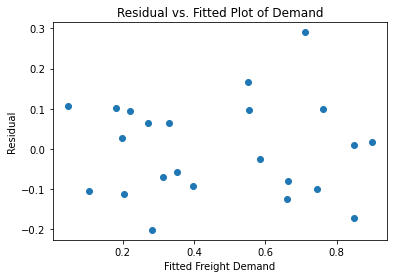

In [49]:
# plot 
plt.scatter(model_demand.fittedvalues, model_demand.resid)
# adding title and labels
plt.xlabel('Fitted Freight Demand')
plt.ylabel('Residual')
plt.title('Residual vs. Fitted Plot of Demand')
plt.savefig("Residual.png",bbox_inches = 'tight')

plt.show()

### GM(1,1) Grey Prediciton Model

In [3]:
from greytheory import GreyTheory
grey = GreyTheory()

gm11 = grey.gm11

gm11.add_pattern(1630, "a1")
gm11.add_pattern(1567, "a2")
gm11.add_pattern(1593, "a3")
gm11.add_pattern(1581, "a4")
gm11.add_pattern(1627, "a5")
gm11.add_pattern(1643, "a6")
gm11.add_pattern(1743.7, "a7")
gm11.add_pattern(1745.9, "a8")
gm11.add_pattern(1775.8, "a9")
gm11.add_pattern(1822.4, "a10")
gm11.add_pattern(1667.5, "a11")
gm11.add_pattern(1356.2, "a12")
gm11.add_pattern(1488.5, "a13")
gm11.add_pattern(1456.6, "a14")
gm11.add_pattern(1426.7, "a15")
gm11.add_pattern(1316.1, "a16")
gm11.add_pattern(1321.7, "a17")
gm11.add_pattern(1445.2, "a18")
gm11.add_pattern(1433.5, "a19")
gm11.add_pattern(1396.6, "a20")
gm11.add_pattern(1405.5, "a21")
gm11.add_pattern(1439.6, "a22")
gm11.add_pattern(1271.8, "a23")

gm11.period = 10 # Default is 1, the parameter means how many next moments need to forcast continually.
gm11.forecast()

# Looks GM11 the results for example as below:
print(gm11.print_forecasted_results())

ModuleNotFoundError: No module named 'greytheory'

In [9]:
data_grey = pd.read_csv('Written_Investigation_DATA_grey.csv')

In [10]:
data_grey

,Year,Orig_Value,Fore_Value
0,1999,1567.0,1711.55
1,2000,1593.0,1692.31
2,2001,1581.0,1673.30
3,2002,1627.0,1654.49
4,2003,1643.0,1635.90
5,2004,1743.7,1617.52
6,2005,1745.9,1599.34
7,2006,1775.8,1581.37
8,2007,1822.4,1563.60
9,2008,1667.5,1546.03


In [11]:
# Plotting
Year=data_grey['Year']
Orig_Value=data_grey['Orig_Value']
Fore_Value=data_grey['Fore_Value']

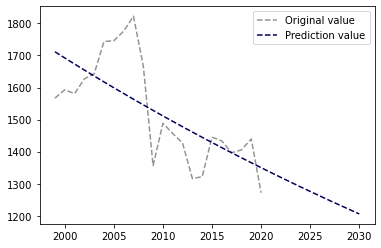

In [23]:
plt.plot(Year,Orig_Value,color='xkcd:grey',linestyle="--",label='Original value')
plt.plot(Year,Fore_Value,color='xkcd:dark blue',linestyle="--",label="Prediction value")
plt.legend(loc='upper right')
plt.savefig("Grey.png",bbox_inches = 'tight')
plt.show()
# https://blog.csdn.net/qq_43202405/article/details/108817523